In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from numpy.random import rand, RandomState
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
import string
from nltk.tokenize import word_tokenize
import matplotlib
from mpl_toolkits.basemap import Basemap
import geopy
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def json_to_dict(filename):
    '''
    INPUT: name of json file
    OUTPUT: dictionary with city keys and description values
    take json file and return dictionary
    '''
    di = {}
    english = []
    with open('wordlist.txt') as f:
        for line in f:
            english.append(line.strip('\r\n'))
            english.append(' ')
    english = set(english)

    with open(filename) as data_file:
        data = json.load(data_file)
        for item in data:
            for key in item.keys():
                # remove punctuation
                txt = ''.join(ch.lower() for ch in item[key] if ch not in set(string.punctuation))
                # remove numbers
                txt = ''.join(c for c in txt if c.isdigit() is False)
                # remove the city name from its own description
                txt = ' '.join(c for c in txt.split() if c != key)
                # remove non-english words
                txt = ' '.join(c for c in txt.split() if c in english)
                # populate dictionary
                di[key.strip().strip('\n').encode('ascii', 'ignore')] = txt
    return di

In [3]:
def combine_dictionaries(dict1, dict2, keys_file):
    '''
    INPUT: dictionaries and keys
    OUTPUT: dictionary with combined data and final key names
    take two dictionaries and combine into one
    '''
    combined_dict = {}
    with open(keys_file) as f:
        for line in f:
            d1_key = line.split('|')[0]
            d2_key = line.split('|')[1]
            final_key = line.split('|')[2]

            if d2_key == 'noname':
                combined_dict[final_key] = dict1.get(d1_key)
            elif d1_key == 'noname':
                combined_dict[final_key] = dict2.get(d2_key)
            else:
                combined_dict[final_key] = dict1.get(d1_key) + dict2.get(d2_key)
    return combined_dict

In [4]:
def remove_stopwords(corpus, words_to_add=[]):
    '''
    INPUT: tokenized document corpus, list of words to remove
    OUTPUT: document corpus with stop words removed
    take a list of words to add to stoplist and remove from corpus
    '''
    '''Use the English language stopwords provided by nltk'''
    stops = stopwords.words('english')
    
    '''Add user-requested stopwords'''
    stops.extend(words_to_add)
    
    '''Remove stop words from corpus and return'''
    #tokenized = [word_tokenize(content.lower()) for content in corpus]
    stops = set(stops)
    docs = [[word for word in words if word not in stops]
        for words in corpus]
    
    return docs

In [5]:
def plot_word_frequencies(tokenized_corpus, title):
    '''
    INPUT: tokenized corpus, plot title
    OUTPUT: vocabulary list, word ids, word counts
    take a tokenized corpus, calculate the frequency of each word, and plot
    '''
    '''Build a vocabulary of every unique word in the corpus'''
    vocab_set = set()
    [[vocab_set.add(token) for token in tokens] for tokens in tokenized_corpus]
    vocab = list(vocab_set)
    
    '''Make a dictionary relating word to id number'''
    vocab_dict = {word: i for i, word in enumerate(vocab)}
    
    '''Build word count matrix'''
    word_ids = np.zeros(len(vocab))
    word_counts = np.zeros((len(tokenized_corpus), len(vocab)))
    for doc_id, words in enumerate(tokenized_corpus):
        for word in words:
            word_id = vocab_dict[word]
            word_ids[word_id] = word_id
            word_counts[doc_id][word_id] += 1
    
    '''Count the total number of times each word occurs'''
    values = np.sum(word_counts, axis=0)
    
    '''Plot the results'''
    plt.bar(range(0,len(values)), sorted(values)[::-1], color='green', alpha=0.4)

    plt.xlabel('Word Index')
    plt.ylabel('Frequency')
    plt.title('Word Frequency Chart - {}'.format(title))
    return np.array(values), vocab, word_ids

In [17]:
# make dictionaries out of trip advisor and wikitravel data
wk_dict = json_to_dict('europe_wiki.json')
ta_dict = json_to_dict('europe_cities.json')

# make a combined dictionary
europe_dict = combine_dictionaries(wk_dict, ta_dict, 'Europe_Dict_Keys.txt')

# Convert dictionary into dataframe
cities_df = pd.DataFrame.from_dict(europe_dict, orient='index', dtype=None)
cities_df.columns = ['description']

# Extract cities and their descripitions from dataframe
doc_bodies = cities_df['description'].values
cities = cities_df.index.values

# Create a tokenized version of the corpus for frequency plots
tokenized_corpus = [word_tokenize(content.lower()) for content in doc_bodies]

## Plot word frequency with nltk stopwords removed

Word in corpus: 13436
Maximum word frequency: 4381


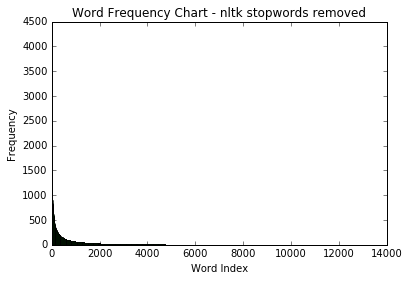

In [18]:
# remove nltk stopwords
tokenized_corpus = remove_stopwords(tokenized_corpus)

# plot the word frequencies
values, vocab, word_ids = plot_word_frequencies(tokenized_corpus, 'nltk stopwords removed')

print 'Word in corpus: {}'.format(len(values))
print 'Maximum word frequency: {}'.format(int(max(values)))

## Plot word frequency with additional words removed
There are additional words in the document that are not useful.  In this section, city and country names, two-letter words, words that appear more than 1000 times and only once are removed.

Word in corpus: 8675
Maximum word frequency: 897


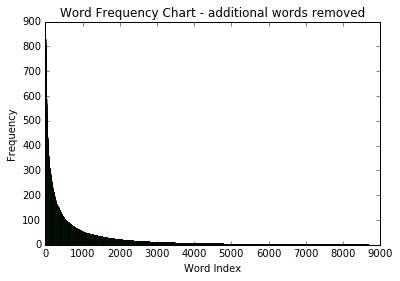

In [29]:
vocab_dict = {i: word for i, word in enumerate(vocab)}

# remove city and country names
city_country_removelist = [c.split(', ') for c in europe_dict.keys()]
city_country_removelist = [item.strip('\n').strip().lower() for sublist in city_country_removelist for item in sublist]

# remove any word that only appears once
uncommonwords = word_ids[values == 1]
uncommon_removelist = [vocab_dict[c] for c in uncommonwords]

# remove any words that appears more than 1000 times
commonwords = word_ids[values > 1000]
common_removelist = [vocab_dict[c] for c in commonwords]

# remove any words that is two letters or fewer
short_removelist = [vocab_dict[c] for c in word_ids if len(vocab_dict[c]) < 3]

# manually build a list of words to remove based on unhelpful results
manual_removelist = ['emile', 'soi', 'alb', 'ugh', 'ebro', 'whit', 'situ', 'zola', 'auk', 'nec', 'rei', 'behalf', 'mis',
                     'inis', 'imam', 'dele', 'delf', 'temps', 'wth', 'concha', 'doa', 'alta', 'hel', 'lev', 'apc',
                     'tai', 'dem', 'fama', 'mori', 'mala', 'avec', 'blah', 'mora', 'kadi', 'buna', 'nuit', 'roux',
                     'leal', 'sola', 'ecce', 'cosa', 'ruta', 'deva', 'cara', 'monde', 'mundi', 'ofthe', 'areal',
                     'forti', 'forty', 'eosin', 'paulo', 'anjou', 'rondo', 'fusee', 'diana', 'buyis', 'pieta', 'motte',
                     'ladys', 'astra', 'mendez', 'udmurt', 'nassau', 'patria', 'nostra', 'plevna', 'majori', 'oeuvre',
                     'forthe', 'herbert', 'psalter', 'macedon', 'minerva', 'ravelin', 'johnsontake', 'main', 'best',
                     'great', 'two', 'area', 'visit', 'day', 'albuquerque', 'gdansk', 'soleil', 'chi', 'mons', 'amis',
                     'vega', 'chios', 'plage', 'cinque', 'england', 'ireland', 'del', 'las', 'sol', 'rue', 'des', 'tel',
                     'pas', 'andorra', 'casa', 'roma', 'city', 'dei', 'one', 'also', 'las', 'des', 'town', 'get', 'del',
                     'costa', 'sol', 'located', 'buy', 'barry', 'cardiff', 'jutland', 'rue', 'muse', 'take', 'seventh',
                     'corso', 'many', 'see', 'learn', 'nine', 'around', 'united', 'search', 'keynes', 'milton', 'yes',
                     'eliot', 'george', 'lenin', 'north', 'south', 'east', 'west', 'mundi', 'mans', 'sleep', 'eat',
                     'drink', 'str', 'street', 'open', 'place', 'people', 'known', 'good', 'way', 'years', 'new',
                     'spain', 'germany', 'mary', 'london', 'europe', 'road', 'first', 'part', 'word', 'right', 'via',
                     'piazza', 'jump', 'ruhr', 'braunschweig', 'fax', 'volga', 'features', 'every', 'kent', 'contents',
                     'entry', 'wed', 'hampshire', 'yorkshire', 'tyne', 'newcastle', 'tatar','notre', 'vieux','enjoy',
                     'palais', 'thames', 'along', 'contact', 'durham', 'patrick', 'sat', 'find', 'admission', 'large',
                     'cheshire', 'county', 'umbria', 'playa', 'bus', 'station', 'state', 'heavily', 'result', 'country',
                     'pueblo', 'local'
                    ]

# Build a combined list of all stopwords
stops = stopwords.words('english')
stop_wds = stops + city_country_removelist + uncommon_removelist + common_removelist +\
           short_removelist + manual_removelist
tokenized_corpus = remove_stopwords(tokenized_corpus, stop_wds)

# remove the words and plot frequencies
values_final, vocab_final, word_ids_final = plot_word_frequencies(tokenized_corpus, 'additional words removed')

print 'Word in corpus: {}'.format(len(values_final))
print 'Maximum word frequency: {}'.format(int(max(values_final)))

## Implement K-means Clustering to group cities by common features

In [30]:
vectorizer = TfidfVectorizer(stop_words=stop_wds)
X = vectorizer.fit_transform(doc_bodies)
features = vectorizer.get_feature_names()
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

# 2. Find the top 10 features for each cluster.
top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-11:-1]
print "top features for each cluster:"
for num, centroid in enumerate(top_centroids):
    print "%d: %s" % (num, ", ".join(features[i] for i in centroid))

# 3. Print out the titles of a random sample of the articles assigned to each
# cluster to get a sense of the topic.
assigned_cluster = kmeans.transform(X).argmin(axis=1)
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X.shape[0])[assigned_cluster == i]
    sample_cities = np.random.choice(cluster, 3, replace=False)
    print "cluster %d:" % i
    for city in sample_cities:
        print "    %s" % cities[city].strip('\n')

top features for each cluster:
0: mosque, turkish, ottoman, bridge, palm, fortress, tower, hill, bazaar, sea
1: festival, university, palace, cathedral, tour, center, music, beautiful, history, tower
2: russian, soviet, war, ukrainian, monument, metro, river, fortress, kremlin, center
3: beach, tuscany, resort, village, beautiful, pueblo, spa, italian, navigation, walls
4: home, house, gallery, football, theatre, castle, hall, club, local, river
5: railway, navigation, kingdom, military, adult, tank, football, collection, fantastic, rail
6: cathedral, castle, saint, center, river, festival, university, house, history, hall
cluster 0:
    Scandicci, Italy
    Ancona, Italy
    Antalya, Turkey
cluster 1:
    Hanover, Germany
    Tallinn, Estonia
    Chester, England
cluster 2:
    Krasnodar, Russia
    Lugansk, Ukraine
    Krasnoyarsk, Russia
cluster 3:
    Massa, Italy
    Livorno, Italy
    Pistoia, Greece
cluster 4:
    Worcester, England
    Maidenhead, England
    Oldham, England
cl

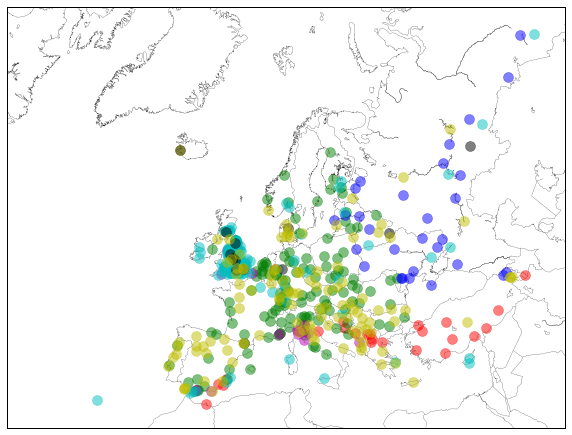

In [31]:
matplotlib.use('Agg')

plt.figure(figsize=(10, 10))
m = Basemap(projection='stere', lon_0=5, lat_0=90.0, rsphere=6371200., llcrnrlon=-25.0,
            urcrnrlon=90.0, llcrnrlat=26.0, urcrnrlat=50.0, resolution='l')

colors = ['r', 'g', 'b', 'm', 'c', 'k', 'y']
geolocator = Nominatim()
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X.shape[0])[assigned_cluster == i]
    for city in cluster:
        location = geolocator.geocode(cities[city], timeout=10)
        if location is not None:
            xpt, ypt = m(location.longitude, location.latitude)
            plt.plot(xpt, ypt, '.', color=colors[i], alpha=0.5, markersize=20)

m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)
plt.savefig('city_clusters.png')
plt.show()